# More Image Colorization Models

In [ ]:
import lmdb
import io
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, RepeatVector, Reshape, concatenate
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16

## Image data preprocessing

In [ ]:
def trim_image(image, height, width):
    image_height = image.shape[0]
    image_width = image.shape[1]
    
    out = image.copy()
    if image_height > height:
        top = (image_height-height)//2
        bottom = image_height-height-top
        out = out[top:-bottom, :, :]
    if image_width > width:
        left = (image_width-width)//2
        right = image_width-width-left
        out = out[:, left:-right, :]
    return out

In [ ]:
def get_image_data(db_path, color_space='RGB', size=None):
    env = lmdb.open(db_path, map_size=1099511627776,
                    max_readers=100, readonly=True)
    images = []
    with env.begin(write=False) as txn:
        cursor = txn.cursor()
        for key, val in cursor:
            # Get image data in bytes
            img = io.BytesIO(val)
            # Convert to numpy array in RGB space
            img = np.array(Image.open(io.BytesIO(val)).convert('RGB'))
            # Trim image from the center
            if size is not None:
              img = trim_image(img, size[0], size[1])
            # Convert color space
            if color_space == 'YUV':
              img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'LAB':
              img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB) 
            # Scale value to be in [0, 1]
            img = img/255.0
            images.append(img)
    return np.array(images)

In [ ]:
images = get_image_data('bedroom_val_lmdb', size=(224,224))

In [ ]:
# Train/test split
idx = tf.range(start=0, limit=tf.shape(images)[0], dtype=tf.int32)
idx_train, idx_test = tf.split(tf.random.shuffle(idx, seed=1), [256, 44], 0)
train_images = images[idx_train]
test_images = images[idx_test]

## Image Colorization using Transfer Learning
This is an implementation of this [notebook](https://github.com/dipanjanS/hands-on-transfer-learning-with-python/blob/master/notebooks/Ch12%20-%20Image%20Colorization/colornet_vgg16.ipynb). Pre-trained VGG16 is used here for object detection in image to help with colorization. 

In [ ]:
#Load weights
vgg16 = VGG16(weights=r'imagenet', include_top=True)

553467904/553467096 [==============================] - 3s 0us/step


In [ ]:
# Model definition
emd_input = Input(shape=(1000,)) # VGG16 output
DIM = 224

#Encoder
enc_input = Input(shape=(DIM, DIM, 1,))
enc_output = Conv2D(64, (3,3), 
                        activation='relu', 
                        padding='same', strides=2)(enc_input)
enc_output = Conv2D(128, (3,3), 
                        activation='relu', 
                        padding='same')(enc_output)
enc_output = Conv2D(128, (3,3), 
                        activation='relu', 
                        padding='same', strides=2)(enc_output)
enc_output = Conv2D(256, (3,3), 
                        activation='relu', 
                        padding='same')(enc_output)
enc_output = Conv2D(256, (3,3), 
                        activation='relu', 
                        padding='same', strides=2)(enc_output)
enc_output = Conv2D(512, (3,3), 
                        activation='relu', 
                        padding='same')(enc_output)
enc_output = Conv2D(512, (3,3), 
                        activation='relu', 
                        padding='same')(enc_output)
enc_output = Conv2D(256, (3,3), 
                        activation='relu', 
                        padding='same')(enc_output)

#Fusion
fusion_layer_output = RepeatVector(28*28)(emd_input) 
fusion_layer_output = Reshape(([28,28,1000]))(fusion_layer_output)
fusion_layer_output = concatenate([enc_output, 
                                   fusion_layer_output], axis=3) 
fusion_layer_output = Conv2D(DIM, (1, 1), 
                       activation='relu', 
                       padding='same')(fusion_layer_output) 

#Decoder
dec_output = Conv2D(128, (3,3), 
                        activation='relu', 
                        padding='same')(fusion_layer_output)
dec_output = UpSampling2D((2, 2))(dec_output)
dec_output = Conv2D(64, (3,3), 
                        activation='relu', 
                        padding='same')(dec_output)
dec_output = UpSampling2D((2, 2))(dec_output)
dec_output = Conv2D(32, (3,3), 
                        activation='relu', 
                        padding='same')(dec_output)
dec_output = Conv2D(16, (3,3), 
                        activation='relu', 
                        padding='same')(dec_output)
dec_output = Conv2D(2, (3, 3), 
                        activation='tanh', 
                        padding='same')(dec_output)
dec_output = UpSampling2D((2, 2))(dec_output)

model = Model(inputs=[enc_input, emd_input], outputs=dec_output)

In [ ]:
emb_x = vgg16.predict(train_images)

In [ ]:
l = []
ab = []
for i in range(images.shape[0]):
    lab = cv2.cvtColor((images[i]*255).astype('uint8'), cv2.COLOR_RGB2LAB)/255.0
    l.append(lab[:,:,:1])
    ab.append(lab[:,:,1:])
l = np.array(l)
ab = np.array(ab)
train_l = l[idx_train]
train_ab = ab[idx_train]
test_l = l[idx_test]
test_ab = ab[idx_test]

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
#Generate training data
BATCH_SIZE = 64
EPOCHS=500
STEPS_PER_EPOCH = 2

In [ ]:
model.fit(x=[train_l, emb_x], y=train_ab, epochs=EPOCHS, batch_size=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/500
2/2 [==============================] - 6s 485ms/step - loss: 0.4854
Epoch 2/500
2/2 [==============================] - 1s 475ms/step - loss: 0.3560
Epoch 3/500
2/2 [==============================] - 1s 480ms/step - loss: 0.4708
Epoch 4/500
2/2 [==============================] - 1s 475ms/step - loss: 0.4717
Epoch 5/500
2/2 [==============================] - 1s 478ms/step - loss: 0.4683
Epoch 6/500
2/2 [==============================] - 1s 482ms/step - loss: 0.4716
Epoch 7/500
2/2 [==============================] - 1s 467ms/step - loss: 0.4704
Epoch 8/500
2/2 [==============================] - 1s 486ms/step - loss: 0.4725
Epoch 9/500
2/2 [==============================] - 1s 475ms/step - loss: 0.4696
Epoch 10/500
2/2 [==============================] - 1s 472ms/step - loss: 0.4715
Epoch 11/500
2/2 [==============================] - 1s 482ms/step - loss: 0.4752
Epoch 12/500
2/2 [==============================] - 1s 478ms/step - loss: 0.4684
Epoch 13/500
2/2 [===================

### Evaluation On Training Set

In [52]:
idx = 1
x = train_l[idx:idx+1]
y_hat = model.predict([x, emb_x[idx:idx+1]])
predict_img = np.concatenate((x[0]*255, y_hat[0]*255), axis=2).astype('uint8')
predict_img = cv2.cvtColor(predict_img, cv2.COLOR_LAB2RGB)
true_img = (train_images[idx]*255).astype('uint8')

Text(0.5, 1.0, 'Ground truth')

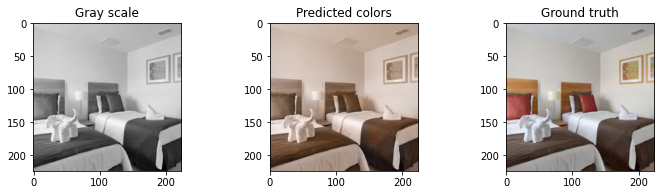

In [53]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(2,3,1)
ax.imshow(np.squeeze(x), cmap='gray')
ax.set_title("Gray scale")

ax = fig.add_subplot(2,3,2)
ax.imshow(predict_img)
ax.set_title('Predicted colors')

ax = fig.add_subplot(2,3,3)
ax.imshow(true_img)
ax.set_title('Ground truth')

### Evaluation On Test Set

In [55]:
idx = 5
x = test_l[idx:idx+1]
y_hat = model.predict([x, vgg16.predict(test_images[idx:idx+1])])
predict_img = np.concatenate((x[0]*255, y_hat[0]*255), axis=2).astype('uint8')
predict_img = cv2.cvtColor(predict_img, cv2.COLOR_LAB2RGB)
true_img = (test_images[idx]*255).astype('uint8')

Text(0.5, 1.0, 'Ground truth')

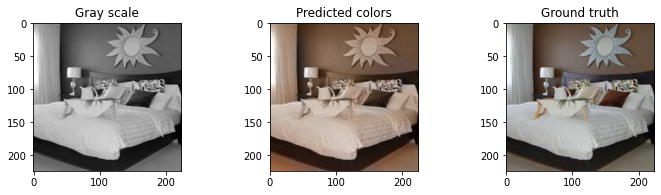

In [56]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(2,3,1)
ax.imshow(np.squeeze(x), cmap='gray')
ax.set_title("Gray scale")

ax = fig.add_subplot(2,3,2)
ax.imshow(predict_img)
ax.set_title('Predicted colors')

ax = fig.add_subplot(2,3,3)
ax.imshow(true_img)
ax.set_title('Ground truth')

## DeOldify API
DeOldify ([Main page](https://deoldify.ai/), [GitHub](https://github.com/jantic/DeOldify)) is a deep learning colorization project developed by Jason Antic. It uses a GAN architecture with pre-train ResNet weights for colorization. 

In [ ]:
import requests
r = requests.post(
    "https://api.deepai.org/api/colorizer",
    files={
        'image': io.BytesIO(cv2.imencode('.jpg', (train_l[1]*255).astype('uint8'))[1]),
    },
    headers={'api-key': 'quickstart-QUdJIGlzIGNvbWluZy4uLi4K'}
)
output_url = r.json()['output_url']

### DeOldify output

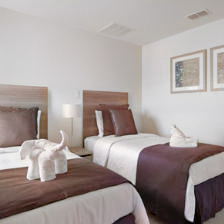

In [ ]:
display(Image.open(requests.get(output_url, stream=True).raw))

### Original image

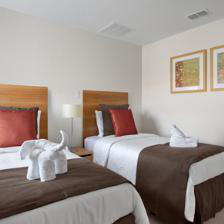

In [ ]:
display(Image.fromarray((images[idx_train][1]*255).astype('uint8')))

Both models seem to suffer from lack of variation in color. This might have to do with the image dataset being of the same scene and that most objects (bedding, furniture, etc.) can be of many different colors. 